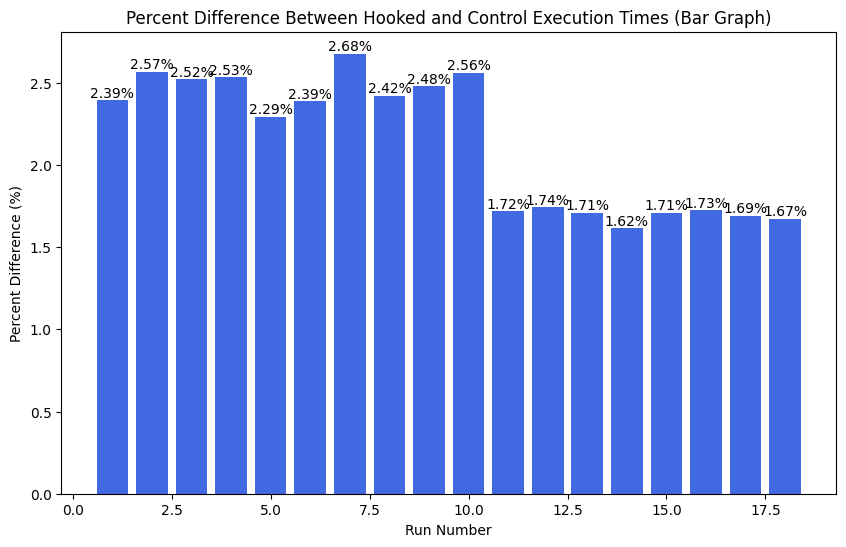

2.1345933997685993


In [ ]:
# Read the control times
control_times = []
hook_times = []
model_sizes = []

with open('control.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(", ")
        # Extract the mean control time and model size
        mean_control_time = float(parts[-1].split(": ")[1].replace('s', ''))
        control_times.append(mean_control_time)
        model_sizes.append(", ".join(parts[:-1]))  # Store model size info (Input, Hidden, Output, Batch)

with open('hook.txt', 'r') as f:
    for line in f:
        parts = line.strip().split(", ")
        # Extract the mean hooked time
        mean_hooked_time = float(parts[-1].split(": ")[1].replace('s', ''))
        hook_times.append(mean_hooked_time)

# Convert to numpy arrays
control_times = np.array(control_times)
hook_times = np.array(hook_times)

# Sanity check: Make sure the lengths match
if len(control_times) != len(hook_times):
    raise ValueError("The number of entries in control.txt and hook.txt must be the same.")

# Calculate percent differences
percent_differences = ((hook_times - control_times) / control_times) * 100

# Plot percent differences
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(percent_differences) + 1), percent_differences, color='royalblue')

# Add values on top of each bar
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
             f'{percent_differences[i]:.2f}%', ha='center', va='bottom')

# Add model size labels to the x-axis
plt.xticks(range(1, len(model_sizes) + 1), model_sizes, rotation=45, ha='right')

plt.xlabel('Model Configuration (Input, Hidden, Output, Batch)')
plt.ylabel('Percent Difference (%)')
plt.title('Percent Difference Between Hooked and Control Execution Times (Bar Graph)')

# Save plot
plt.tight_layout()
plt.savefig('percent_difference_bar_plot.png')

# Show plot
plt.show()

# Save the percent differences to a file with model size information
with open('percent_differences.txt', 'w') as f:
    f.write("Model Configuration, Percent Difference (%)\n")
    for model_size, percent_diff in zip(model_sizes, percent_differences):
        f.write(f"{model_size}, {percent_diff:.4f}\n")

# Print the mean percent difference
mean_percent_difference = np.mean(percent_differences)
print(f"Mean Percent Difference: {mean_percent_difference:.2f}%")

## Takeaways 
A conventional SGD model w forward and backwards hooks is around 2.5% slower. This is a negligble overhead, telling us that hooks are not a good place to target for optimizations. Additionally, this overhead decreases as one increases the tensor sizes. Increasing the second parameter in the second linear layer from 100 to 1000 drops the percent difference to around 1.75% which can be seen in the iterations after 10. Doubling the second parameter of linear 1 from 4000 to 8000, and first param of linear 2 to the same we notice

In [ ]:
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
import csv
from typing import List, Tuple

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model class
class Model(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int):
        super(Model, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Hook functions
def forward_hook(module, input, output):
    _ = output.mean().item()

def backward_hook(module, grad_input, grad_output, max_norm=1.0):
    total_norm = torch.norm(torch.stack([torch.norm(g) for g in grad_output if g is not None]))
    
    # Scale the gradients if the norm exceeds the max_norm
    if total_norm > max_norm:
        scale = max_norm / (total_norm + 1e-6)  # Add epsilon to avoid division by zero
        for grad in grad_output:
            if grad is not None:
                grad.mul_(scale) 

# Function to attach hooks to a model
def attach_hooks(model: nn.Module) -> List[torch.utils.hooks.RemovableHandle]:
    hook_handles = []
    for module in model.modules():
        if isinstance(module, nn.Linear):
            hook_handles.append(module.register_forward_hook(forward_hook))
            hook_handles.append(module.register_backward_hook(lambda module, grad_input, grad_output: backward_hook(module, grad_input, grad_output, max_norm=1.0)))
    return hook_handles

# Function to remove hooks
def remove_hooks(hook_handles: List[torch.utils.hooks.RemovableHandle]):
    for handle in hook_handles:
        handle.remove()

# Function to profile a model
def profile_model(model: nn.Module, x: torch.Tensor, y: torch.Tensor, iterations: int) -> List[float]:
    times = []
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    for _ in range(iterations):
        torch.cuda.synchronize()
        start_time = time.time()

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        torch.cuda.synchronize()
        end_time = time.time()

        times.append(end_time - start_time)
    
    return times

# Function to run experiments
def run_experiment(input_size: int, hidden_size: int, output_size: int, batch_size: int, iterations: int) -> Tuple[float, float]:
    # Initialize models
    control_model = Model(input_size, hidden_size, output_size).to(device)
    hooked_model = Model(input_size, hidden_size, output_size).to(device)

    # Attach hooks to the hooked model
    max_norm = 1.0
    hook_handles = attach_hooks(hooked_model, max_norm)

    # Generate random data
    x = torch.randn(batch_size, input_size).to(device)
    y = torch.randn(batch_size, output_size).to(device)

    # Profile models
    time_control_list = profile_model(control_model, x, y, iterations)
    time_hooked_list = profile_model(hooked_model, x, y, iterations)

    # Remove hooks
    remove_hooks(hook_handles)

    # Calculate mean times
    mean_control = np.mean(time_control_list)
    mean_hooked = np.mean(time_hooked_list)

    # Save results to files with model size information
    with open('control.txt', 'a') as f:
        f.write(f"Input: {input_size}, Hidden: {hidden_size}, Output: {output_size}, Mean Control Time: {mean_control:.6f}s\n")

    with open('hook.txt', 'a') as f:
        f.write(f"Input: {input_size}, Hidden: {hidden_size}, Output: {output_size}, Mean Hooked Time: {mean_hooked:.6f}s\n")

    # Save results to a CSV file
    with open('profiling_results.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow([input_size, hidden_size, output_size, mean_control, mean_hooked])

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations), time_control_list, label='Control (No Hooks)', marker='o')
    plt.plot(range(iterations), time_hooked_list, label='Hooked (Forward + Backward Hooks)', marker='x')
    plt.xlabel('Iteration')
    plt.ylabel('Execution Time (seconds)')
    plt.title(f'Profiling Results: Control vs Hooked Model\nInput: {input_size}, Hidden: {hidden_size}, Output: {output_size}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'profiling_results_{input_size}_{hidden_size}_{output_size}.png')
    plt.show()

    return mean_control, mean_hooked

def main():
    experiments = [
        (2**10, 2**9, 2**8, 2**7, 100),  # (input_size, hidden_size, output_size, batch_size, iterations)
        (2**9, 2**8, 2**7, 2**6, 50),
        (2**8, 2**7, 2**6, 2**5, 30)
    ]

    for input_size, hidden_size, output_size, batch_size, iterations in experiments:
        print(f"Running experiment with Input: {input_size}, Hidden: {hidden_size}, Output: {output_size}")
        mean_control, mean_hooked = run_experiment(input_size, hidden_size, output_size, batch_size, iterations)
        print(f"Mean Control Time: {mean_control:.6f}s, Mean Hooked Time: {mean_hooked:.6f}s\n")

if __name__ == "__main__":
    main()